<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/GAN/WGANGP_Cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP (Wasserstein GAN Gradient Penalty)

元論文 >> Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを -c <= param <= cにクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（= GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

## アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

## Generator

ResNetの活性化関数はReLU

<img src='images/WGANGP_G.png' width=600>

## Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='images/WGANGP_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='images/WGANGP_resblock.png' width=500>



# Import and Config

In [27]:
!pip install -q --upgrade albumentations==0.5.1

In [28]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [29]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# Define Model

In [44]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class Reshape(nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x

# ResNet block
class ResBlock(nn.Module):
    def __init__(self, dim_first=None, dim=64, activation_fn=nn.ReLU(), batch_norm=False):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        #else:
        if batch_norm:
            self.skip_conv = nn.Sequential(
                nn.BatchNorm2d(dim_first),
                activation_fn,
                nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            )
        else:
            self.skip_conv = nn.Sequential(
                activation_fn,
                nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
            )
        
        if batch_norm:
            self.block = nn.Sequential(
                nn.BatchNorm2d(dim_first),
                activation_fn,
                nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(dim),
                activation_fn,
                nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            )
        else:
            self.block = nn.Sequential(
                activation_fn,
                nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                activation_fn,
                nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            )


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        return F.relu(res_x + x)


class Generator(nn.Module):
    def __init__(self, class_num=10, dim=32, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Generator, self).__init__()

        self.module = nn.Sequential(
            nn.Linear(100, (in_height // 8) * (in_width // 8) * dim, bias=False),
            Reshape(dim, in_height // 8, in_width // 8),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            ResBlock(dim=dim, batch_norm=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            ResBlock(dim=dim, batch_norm=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            ResBlock(dim=dim, batch_norm=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(dim, in_channel, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.module(x)


class Discriminator(torch.nn.Module):
    def __init__(self, class_num=10, dim=32, in_height=IN_HEIGHT, in_width=IN_WIDTH, in_channel=3):
        super(Discriminator, self).__init__()

        self.module = nn.Sequential(
            ResBlock(dim_first=in_channel, dim=dim, activation_fn=nn.LeakyReLU(0.2), batch_norm=False),
            nn.AvgPool2d(2, stride=2),
            ResBlock(dim=dim, activation_fn=nn.LeakyReLU(0.2), batch_norm=False),
            nn.AvgPool2d(2, stride=2),
            ResBlock(dim=dim, activation_fn=nn.LeakyReLU(0.2), batch_norm=False),
            ResBlock(dim=dim, activation_fn=nn.LeakyReLU(0.2), batch_norm=False),
            nn.ReLU(),
            nn.Conv2d(dim, 1, kernel_size=[in_height // 4, in_width // 4], padding=0, stride=1),
            Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.module(x)


# Dataset

In [31]:
class Cifar10Dataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx] / 127.5 - 1
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

In [32]:
transforms_train = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    # A.Resize(IN_HEIGHT, IN_WIDTH),
    # A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [33]:
def show_sample(Xs, show_num=10, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="gray")
        plt.title(name)
        plt.axis('off')
        
    plt.show()


In [46]:
def train():
    train_models = []
    train_model_paths = []

    EPOCH = 50
        
    train_losses_d = []
    train_losses_g = []
        
    #---
    # datasert
    #---
    batch_size = 256

    train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
    train_Xs = train_ds.data.astype(np.float32)
    train_ys = np.array(train_ds.targets)

    dataset_train = Cifar10Dataset(train_Xs, train_ys, transforms=transforms_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)

    train_n = len(dataloader_train)

    #---
    # model
    #---
    gen = Generator().to(device)
    dis = Discriminator().to(device)

    criterion = nn.BCELoss()

    opt_d = torch.optim.Adam(dis.parameters(), lr=0.0001, betas=(0.5, 0.9))
    opt_g = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.9))

    # opt_d = torch.optim.RMSprop(dis.parameters(), lr=0.0005)
    # opt_g = torch.optim.RMSprop(gen.parameters(), lr=0.0005)

    #---
    # WGAN hyper params
    #---
    Clip_value = 0.01
    Critic_time = 5

    #---
    # epoch
    #---
    for epoch in range(EPOCH):
        gen.train()
        dis.train()
        
        tr_loss_d = 0
        tr_loss_g = 0
        total = 0
        
        #---
        # train
        #---
        train_time_start = time.time()
        
        for step, batch in enumerate(dataloader_train):
            opt_g.zero_grad()

            xs = batch[0].to(device)
            ys = batch[1]

            _batch_size = len(xs)

            ones = torch.ones([_batch_size, 1]).to(device)
            zeros = torch.zeros([_batch_size, 1]).to(device)

            #---
            # update discriminator
            #---

            for c_time in range(Critic_time):
                opt_d.zero_grad()

                # real x
                y_real = dis(xs)
                loss_real = torch.mean(y_real)

                # fake x
                zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
                zs = torch.tensor(zs, dtype=torch.float).to(device)
                x_fake = gen(zs)
                y_fake = dis(x_fake)
                loss_fake = torch.mean(y_fake)

                #---
                # Gradient Penalty
                #---
                # sample epsilon from [0, 1]
                epsilon = np.random.random()

                # sample x_hat 
                x_hat = (epsilon * xs + (1 - epsilon) * x_fake).requires_grad_(True)
                
                Dx_hat = dis(x_hat)
                musk = torch.ones_like(Dx_hat)
                gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
                gradients = gradients.reshape(-1, 1)
                gradient_penalty = 10 * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

                #---
                # total loss
                #---
                loss_d = loss_real - loss_fake + gradient_penalty
                loss_d.backward()
                opt_d.step()

                tr_loss_d += loss_d.item() / train_n / Critic_time

            #---
            # update generator
            #--- 
            opt_d.zero_grad()
            opt_g.zero_grad()

            zs = np.random.uniform(-1, 1, size=(_batch_size, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)
            x_fake = gen(zs)
            y_fake = dis(x_fake)
            loss_g = y_fake.mean(0).view(1)
            loss_g.backward()
            opt_g.step()

            tr_loss_g += loss_g.item() / train_n

        train_losses_d.append(tr_loss_d)
        train_losses_g.append(tr_loss_g)

        train_time_end = time.time()

        train_time_total = train_time_end - train_time_start
            
        print(f"epoch:{epoch + 1}/{EPOCH} [tra]loss-d:{tr_loss_d:.4f} loss-g:{tr_loss_g:.4f} [time]tra:{train_time_total:.2f}sec")

        if (epoch + 1) % 100 == 0:
            savename = f"model_epoch{epoch + 1}_{EPOCH}.pth"
            torch.save(gen.state_dict(), savename)
            print(f"model saved to >> {savename}")

        if (epoch + 1) % 5 == 0:
            show_sample(x_fake, name="output")

    #---
    # save model
    #---
    savename = f"model_epoch{EPOCH}.pth"
    torch.save(gen.state_dict(), savename)
    print(f"model saved to >> {savename}")
    print()
    
    train_models.append(gen)
    train_model_paths.append(savename)
    

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.grid()
    ax1.plot(train_losses_d, marker=".", markersize=6, color="red", label="train loss d")
    ax1.plot(train_losses_g, marker=".", markersize=6, color="blue", label="train loss g")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    ax1.set(xlabel="Epoch", ylabel="Loss")
    plt.show()

        
    return train_models, train_model_paths


Files already downloaded and verified
epoch:1/50 [tra]loss-d:9.2091 loss-g:0.9240 [time]tra:134.12sec
epoch:2/50 [tra]loss-d:9.0827 loss-g:0.9624 [time]tra:134.09sec
epoch:3/50 [tra]loss-d:9.0275 loss-g:0.9598 [time]tra:134.01sec
epoch:4/50 [tra]loss-d:9.0216 loss-g:0.9482 [time]tra:133.99sec
epoch:5/50 [tra]loss-d:9.0306 loss-g:0.9417 [time]tra:134.01sec


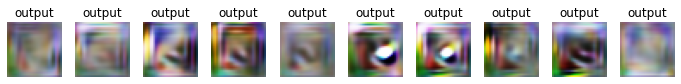

epoch:6/50 [tra]loss-d:9.0750 loss-g:0.8859 [time]tra:134.02sec
epoch:7/50 [tra]loss-d:9.1137 loss-g:0.8609 [time]tra:134.06sec
epoch:8/50 [tra]loss-d:9.2087 loss-g:0.8391 [time]tra:134.13sec
epoch:9/50 [tra]loss-d:9.2930 loss-g:0.8502 [time]tra:134.09sec
epoch:10/50 [tra]loss-d:9.2210 loss-g:0.8651 [time]tra:134.01sec


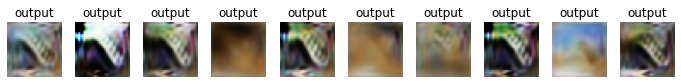

epoch:11/50 [tra]loss-d:9.1740 loss-g:0.8712 [time]tra:134.01sec
epoch:12/50 [tra]loss-d:9.1782 loss-g:0.8664 [time]tra:134.00sec
epoch:13/50 [tra]loss-d:9.1381 loss-g:0.8833 [time]tra:134.08sec
epoch:14/50 [tra]loss-d:9.1292 loss-g:0.8850 [time]tra:133.99sec
epoch:15/50 [tra]loss-d:9.1274 loss-g:0.8906 [time]tra:134.08sec


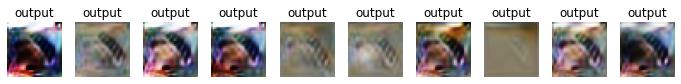

epoch:16/50 [tra]loss-d:9.1964 loss-g:0.8581 [time]tra:134.04sec
epoch:17/50 [tra]loss-d:9.1675 loss-g:0.8762 [time]tra:133.98sec
epoch:18/50 [tra]loss-d:9.1521 loss-g:0.8805 [time]tra:134.05sec
epoch:19/50 [tra]loss-d:9.2158 loss-g:0.8667 [time]tra:134.00sec
epoch:20/50 [tra]loss-d:9.2320 loss-g:0.8466 [time]tra:134.05sec


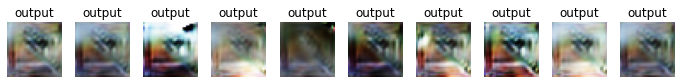

epoch:21/50 [tra]loss-d:9.2322 loss-g:0.8358 [time]tra:133.98sec
epoch:22/50 [tra]loss-d:9.1953 loss-g:0.8353 [time]tra:134.02sec
epoch:23/50 [tra]loss-d:9.1684 loss-g:0.8538 [time]tra:133.99sec
epoch:24/50 [tra]loss-d:9.2116 loss-g:0.8411 [time]tra:134.01sec
epoch:25/50 [tra]loss-d:9.1664 loss-g:0.8552 [time]tra:134.04sec


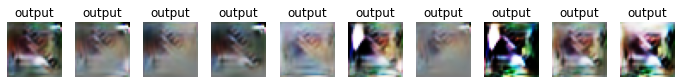

epoch:26/50 [tra]loss-d:9.2575 loss-g:0.8314 [time]tra:134.04sec
epoch:27/50 [tra]loss-d:9.2126 loss-g:0.8520 [time]tra:134.06sec
epoch:28/50 [tra]loss-d:9.1460 loss-g:0.9028 [time]tra:134.13sec
epoch:29/50 [tra]loss-d:9.1532 loss-g:0.8782 [time]tra:134.20sec
epoch:30/50 [tra]loss-d:9.2047 loss-g:0.8553 [time]tra:134.20sec


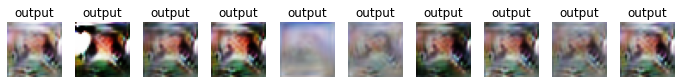

epoch:31/50 [tra]loss-d:9.3933 loss-g:0.6878 [time]tra:134.10sec
epoch:32/50 [tra]loss-d:9.5158 loss-g:0.5560 [time]tra:134.19sec
epoch:33/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.15sec
epoch:34/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.09sec
epoch:35/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.13sec


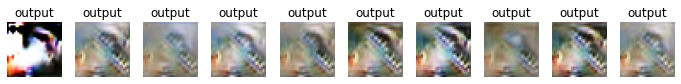

epoch:36/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.16sec
epoch:37/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.15sec
epoch:38/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.13sec
epoch:39/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.11sec
epoch:40/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec


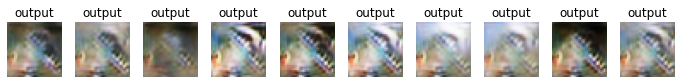

epoch:41/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec
epoch:42/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.21sec
epoch:43/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec
epoch:44/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.11sec
epoch:45/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec


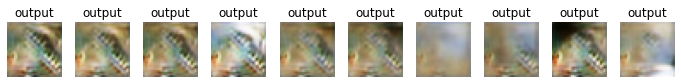

epoch:46/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec
epoch:47/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.21sec
epoch:48/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.16sec
epoch:49/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.16sec
epoch:50/50 [tra]loss-d:10.0000 loss-g:0.0000 [time]tra:134.17sec


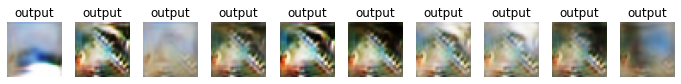

model saved to >> model_epoch50.pth



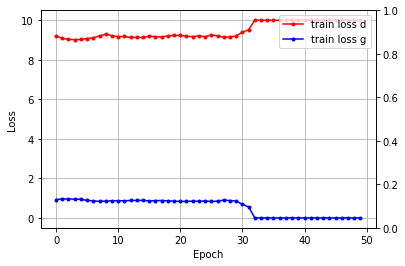

In [47]:
train_models, train_model_paths = train()

# Test

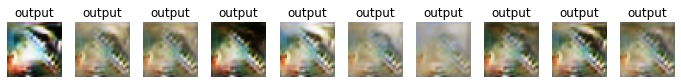

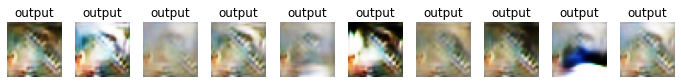

In [48]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    with torch.no_grad():
        model = train_models[0]

        for _ in range(2):
            zs = np.random.uniform(-1, 1, size=(10, 100))
            zs = torch.tensor(zs, dtype=torch.float).to(device)

            xs = model(zs)
            show_sample(xs, name="output")

test(train_models)